In [1]:
from lxml import etree as ET
from argparse import ArgumentParser
import sys
from os import path
from collections import defaultdict
import matplotlib.pyplot as plt
import random
import numpy as np
import glob

In [2]:
def type_token_ratio(toks, n=None, method="abs"):
    if method == "abs":
        tok_count = len(toks)
        type_count = len(set(toks))
    if method == "samp":
        tok_count = n if n is not None else 50000
        r = 5
        type_counts = [len(set(random.sample(toks, tok_count))) for _ in range(r)]
        type_count = sum(type_counts)/r
    if method == "sttr":
        chunk_size = n if n is not None else 1000
        chunks = len(toks)//1000
        total = 0
        for chunk in range(chunks):
            start = chunk * chunk_size
            end = start + chunk_size
            ttr = type_token_ratio(toks[start:end])
            total += ttr
        return total / chunks
    return type_count / tok_count


In [3]:
def org_files(files):
    orged_files = defaultdict(lambda: defaultdict(list))
    for file in files:
        author = path.basename(path.dirname(path.dirname(file)))
        work = path.basename(path.dirname(file))
        orged_files[author][work].append(file)
    return orged_files

# Reading in the data

In [4]:
tokens = defaultdict(list)
work_bounds = defaultdict(list)

In [5]:
files = glob.glob("../tei/*/*/*")
orged_files = org_files(files)


In [6]:
ns = {"tei": "http://www.tei-c.org/ns/1.0"}
for author, works in orged_files.items():
    print(f"Working on {author}...")
    for work, files in sorted(works.items(), key= lambda x: x[0]):
        work_bounds[author].append({"work": work, "index":len(tokens[author])})
        for file in files:
            doc = path.basename(file)
            work = path.basename(path.dirname(file))
            author = path.basename(path.dirname(path.dirname(file)))
            with open(file, "rb") as xml_file:
                tree = ET.parse(xml_file)
            root = tree.getroot()
            words = root.findall(".//tei:w", ns)
            for w in words:
                tokens[author].append((w.text.lower(), w.attrib["lemma"]))


Working on mao...
Working on bernstein...
Working on marx_engels...
Working on kautsky...
Working on luxemburg...
Working on gramsci...
Working on thaelmann...
Working on lenin...
Working on stalin...
Working on trotzki...


# Calculating TTR 

In [71]:
ttr_for_all = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

for author, toks in tokens.items():
        for m in ["abs", "samp", "sttr"]:
            ttr = type_token_ratio([t[0] for t in toks], method=m)
            ttr_for_all[author][m] = ttr

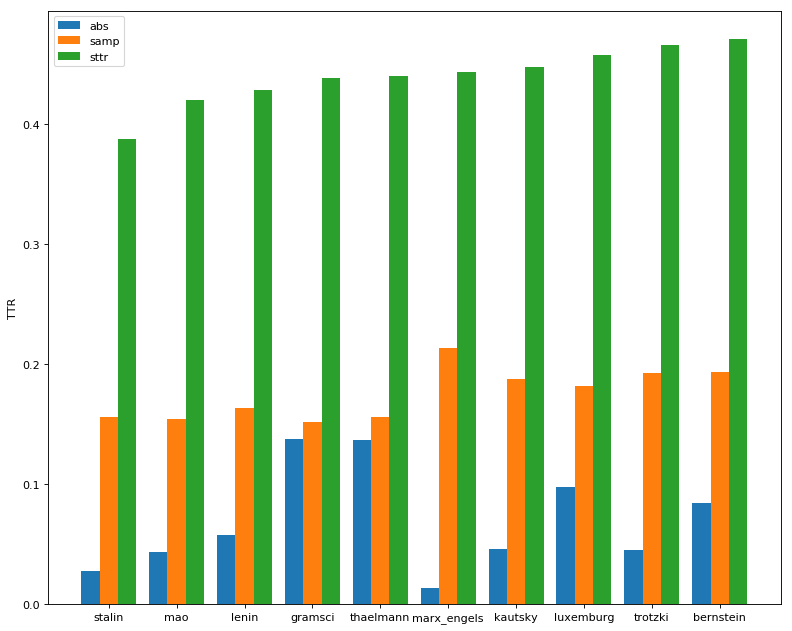

In [74]:
authors = sorted(ttr_for_all.keys(), key= lambda x: ttr_for_all[x]["sttr"])


abs_values = [ttr_for_all[a]["abs"] for a in authors]
samp_values = [ttr_for_all[a]["samp"] for a in authors]
sttr_values = [ttr_for_all[a]["sttr"] for a in authors]

x = np.arange(len(authors))  # the label locations
width = 0.27  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 8), dpi= 80)
rects1 = ax.bar(x - width, abs_values, width, label='abs')
rects2 = ax.bar(x, samp_values, width, label='samp')
rects3 = ax.bar(x + width, sttr_values, width, label="sttr")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('TTR')
ax.set_xticks(x)
ax.set_xticklabels(authors)
ax.legend()


fig.tight_layout()
plt.savefig("ttr.png", format="png")
plt.show()

# Showing term distribution

In [7]:
def find_term(toks, term):
    indices = []
    for i, t in enumerate(toks):
        if t == term:
            indices.append(i)
    return indices

In [8]:
def term_freq(term_locs, total_toks, window_size=10000, step_size=10000):
    values = []
    for i in range(total_toks//step_size):
        start = i * step_size
        end = start + window_size
        matches = len([v for v in term_locs if start <= v < end])
        values.append(matches)
    return values 

In [49]:
terms = ["wert", "ware", "widerspruch", "dialektik"]

## All in One

In [33]:
toks = [t[1].lower() for t in tokens["marx_engels"]]
terms_locs = [find_term(toks, t) for t in terms]

In [45]:
window_size = 1000
values = [term_freq(tl, len(toks), window_size) for tl in terms_locs]

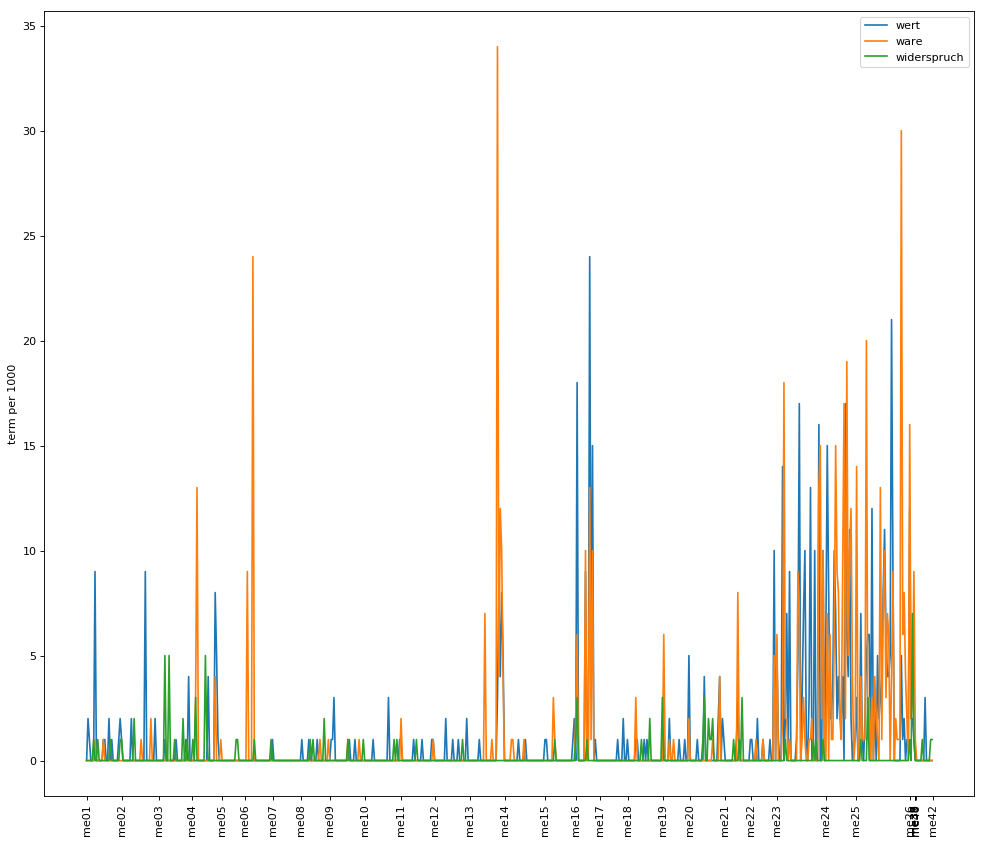

In [46]:
fig, ax = plt.subplots(figsize=(15, 13), dpi= 80)

for i in range(len(values)):
    ax.plot(values[i], label=terms[i])

ax.legend()
ax.set_ylabel(f"term per {window_size}")
ticks = [w["index"]/10000 for w in work_bounds["marx_engels"]]
tick_labels = [w["work"] for w in work_bounds["marx_engels"]]

ax.set_xticks(ticks)
ax.set_xticklabels(tick_labels)
plt.xticks(rotation=90)

plt.show()

## Work by work

In [47]:
# reconstructing the works
works = []
for w, next_w in zip(work_bounds["marx_engels"], work_bounds["marx_engels"][1:]):
    start = w["index"]
    end = next_w["index"]
    works.append({"work": w["work"], "tokens": tokens["marx_engels"][start:end]})

In [59]:
# calculate using parameters
window_size = 500
step_size = 50
all_y_values = []
for i, work in enumerate(works):
    toks = [t[1].lower() for t in work["tokens"]]
    locs = [find_term(toks, t) for t in terms]
    all_y_values.append([term_freq(l, len(toks), window_size, step_size) for l in locs])

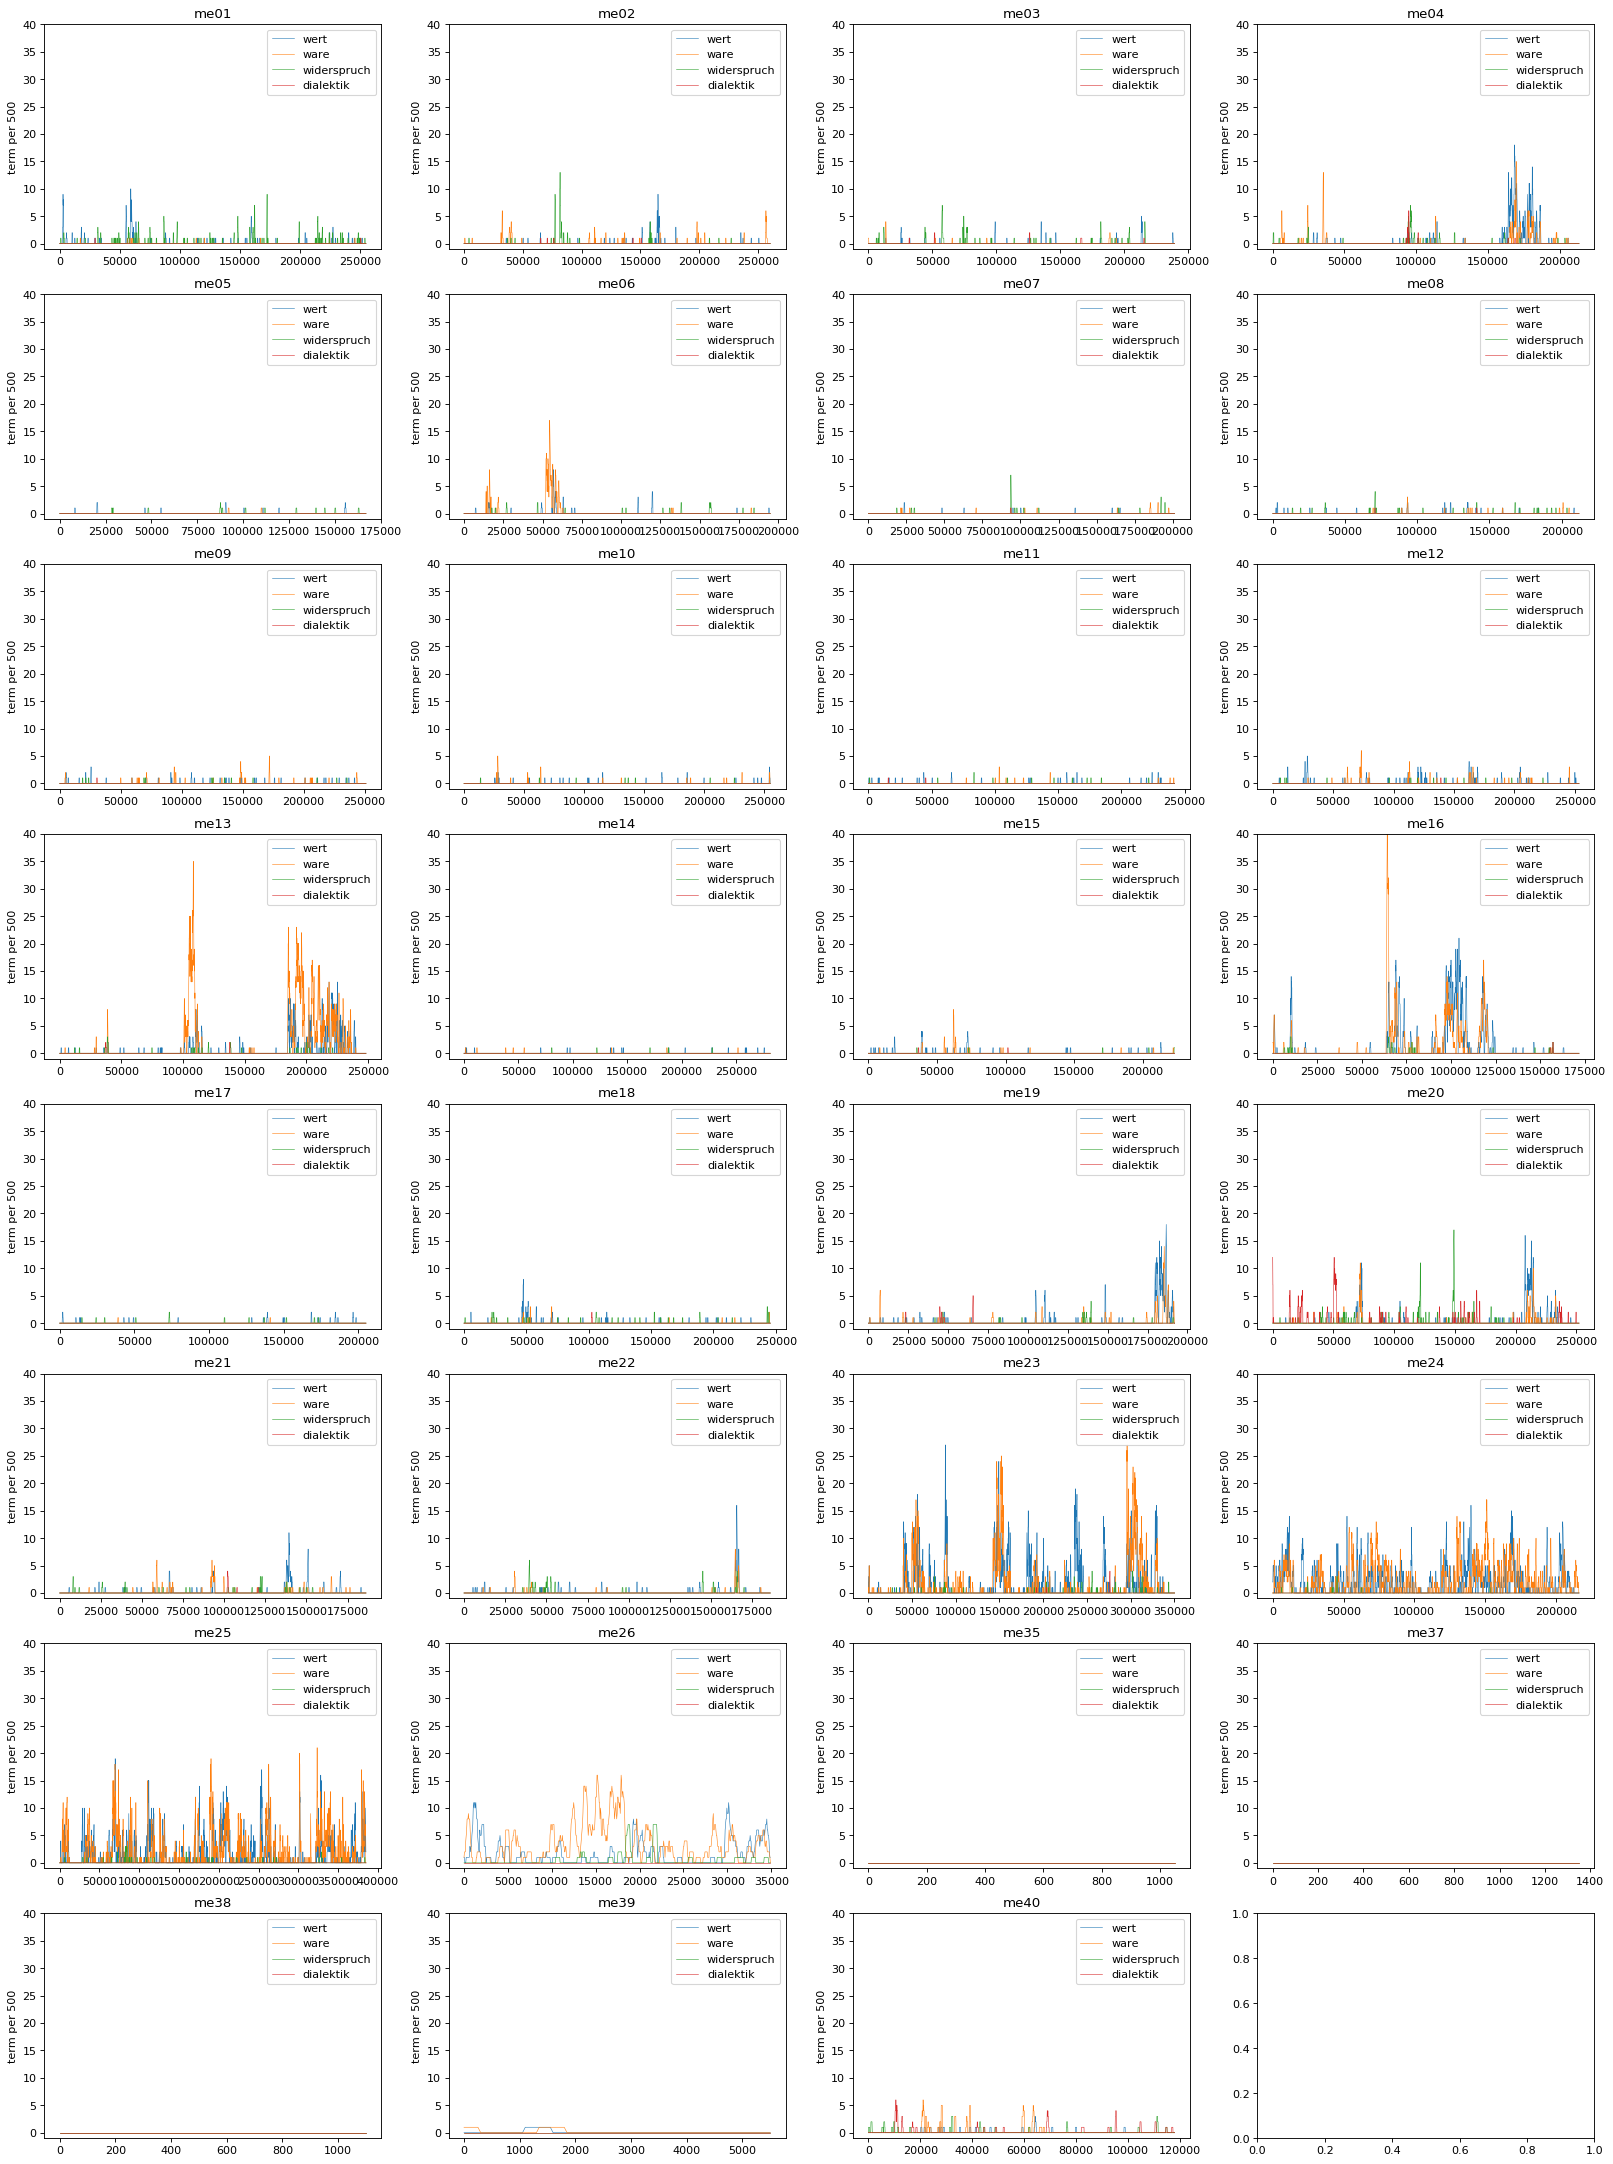

In [60]:
# visualize
fig, axes = plt.subplots(8, 4, figsize=(25, 35), dpi= 80)

for i, work in enumerate(works):
    ax = axes[i//4][i%4]    
    ax.set_ylim(-1,40)
    
    y_values = all_y_values[i]
    x_values = [i*step_size for i in range(len(y_values[0]))]
    
    for i in range(len(y_values)):
        ax.plot(x_values, y_values[i], label=terms[i], linewidth=.5)
    

    ax.legend()
    ax.set_ylabel(f"term per {window_size}")

    ax.set_title(work["work"])
        
plt.savefig("wert_ware_in_me.png", format="png")